In [1]:
import bs4; print( 'bs4 ' + bs4.__version__)
from bs4 import BeautifulSoup, SoupStrainer

import sklearn; print( 'sklearn ' + sklearn.__version__)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

import nltk; print( 'nltk ' + nltk.__version__)
from nltk import word_tokenize, pos_tag, RegexpParser;
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, LancasterStemmer

# from autocorrect import spell; print('autocorrect 0.3.0')

import re; print('re ' + re.__version__)
import requests; print('requests ' + requests.__version__)

import pandas as pd; print('pandas ' + pd.__version__)
import seaborn as sns; print('seaborn ' + sns.__version__)

bs4 4.6.3
sklearn 0.19.1
nltk 3.3
re 2.2.1
requests 2.19.1
pandas 0.22.0
seaborn 0.8.1


# Final Project - Topic Modeling

First we continue where we left off with [Homework 5](https://github.com/kjprice/smu-nlp/blob/e769b93945e6f45ae90aab3ec53b6595ae7bc7da/homework/Homework%205.ipynb).

### Code from Homework 5


In [2]:
# The home page for various movies' reviews, from which will get the links for individual reviews
review_home_urls = {
    'green_mile': 'https://www.imdb.com/title/tt0120689/reviews?ref_=tt_ql_3',
    'forest_gump': 'https://www.imdb.com/title/tt0109830/reviews?ref_=tt_ov_rt',
    'cast_away': 'https://www.imdb.com/title/tt0162222/reviews?ref_=tt_ov_rt',
    'terminal': 'https://www.imdb.com/title/tt0362227/reviews?ref_=tt_ql_3',
    'catch_me_if_you_can': 'https://www.imdb.com/title/tt0264464/reviews?ref_=tt_ql_3',
    'road_to_perdition': 'https://www.imdb.com/title/tt0257044/reviews?ref_=tt_ql_3',
}
def get_text_from_url(url):
    return requests.get(url).text
text = get_text_from_url(review_home_urls['green_mile'])


In [3]:
def get_all_links_from_html(html):
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a', href=True))
    urls = [str(tag.attrs['href']) for tag in tags]
    return urls
all_links = get_all_links_from_html(text)

In [4]:
def get_review_urls_from_links(links):
    url_template = 'https://www.imdb.com{}'
    # url_template = 'http://www.gutenberg.org/files/{}/{}-h/{}-h.htm'
    return [url_template.format(link) for link in links]

urls = get_review_urls_from_links(all_links)

In [5]:
def relevent_link(link):
    if '/review/' in link:
        return True
    return False

In [6]:
def get_relevent_links(links):
    relevent_links = filter(relevent_link, all_links)
    unique_relevent_links = set(relevent_links)
    return list(unique_relevent_links)
relevent_urls = get_relevent_links(urls)
len(relevent_urls)

25

In [7]:
def strain_content(name, attrs):
    if name == 'div' and dict(attrs).get('class', None) == 'content':
        return True
    return False
def clean_review_text(text):
    return re.split('\\n\\n\s+\d+ out of \d+', text)[0]
def get_review_from_url(url):
    html = get_text_from_url(url)
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer(strain_content))
    review = clean_review_text(tags.text)
    return review

In [8]:
def get_review_from_site(url):
    reviews = []

    reviews_home_text = get_text_from_url(url)
    all_links = get_all_links_from_html(reviews_home_text)
    relevent_links = get_relevent_links(all_links)

    
    
    
    review_urls = get_review_urls_from_links(relevent_links)
    for url in review_urls:
        reviews.append(get_review_from_url(url))
        # break
    return reviews

In [9]:
def get_reviews_from_all_sites():
    all_reviews = []
    review_titles = review_home_urls.keys()
    for title in review_titles:
        review_home_url = review_home_urls[title]
        all_reviews = all_reviews + get_review_from_site(review_home_url)
    return all_reviews

## Retrieve All Reviews

In [10]:
all_reviews = get_reviews_from_all_sites()

In [11]:
len(all_reviews)

150

In [12]:
all_reviews[0][0:100]

'\nNow a resident in a rest home, one time head warden on death row, Paul Edgecomb, is struggling with'

## Preprocess Data

In [13]:
def sentences_to_words(sentences):
    return [word_tokenize(sentence) for sentence in sentences]
# sentences_to_words([all_reviews[0]])[0][0:5]

In [14]:
custom_stop_words = ['the', 'green', 'mile', 'shawshank', 'redemption', 'one']
stop_words = custom_stop_words + stopwords.words('english')
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]
remove_stop_words(['he', 'her', 'boss', '.', 'the'])

['boss', '.']

In [15]:
def include_only_numbers_and_letters(words):
    regex_matcher = '^[a-zA-Z0-9]+$'
    return [word for word in words if re.match(regex_matcher, word)]
# include_only_numbers_and_letters(['1', 'KJ', '.'])

In [16]:
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer('english')
stemmer = LancasterStemmer()
def lemmatize_words(words):
    return [stemmer.stem(word) for word in words]
# lemmatize_words(['running', 'fastest', 'hats'])

In [17]:
def preprocess_documents(documents):
    documents_with_formatted_words = [document.lower().strip() for document in documents]
    documents_of_words = sentences_to_words(documents_with_formatted_words)
    content_words_and_characters = [remove_stop_words(words) for words in documents_of_words]
    content_words = [include_only_numbers_and_letters(characters) for characters in content_words_and_characters]
    #lematized_words = [lemmatize_words(words) for words in content_words]
    return content_words  
preprocess_documents(all_reviews[0:2])[0][0:5]

['resident', 'rest', 'home', 'time', 'head']

In [18]:
documents_of_words = preprocess_documents(all_reviews)
documents_of_words[0][0:7]

['resident', 'rest', 'home', 'time', 'head', 'warden', 'death']

### Take a look at words

In [19]:
list_of_all_words = [word for document in documents_of_words for word in document]
len(list_of_all_words)

17454

In [20]:
# Unique Words
len(set(list_of_all_words))

1330

### Flatten documents back to sentences

In [21]:
flattened_documents = [' '.join(document) for document in documents_of_words]

## Perform Topic Modeling

Inspired, in part by https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [57]:
# Settings
NUMBER_OF_FEATURES = 1000
NUMBER_OF_TOPICS  = 12
NUMBER_OF_TOP_WORDS = 10

In [58]:
# Helper function 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}:".format(topic_idx))
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print (stuff)

### Vectorize (Bag Of Words)

In [59]:
tf_vectorizer = CountVectorizer(max_features=NUMBER_OF_FEATURES)
tf = tf_vectorizer.fit_transform(flattened_documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [60]:
flattened_documents[0][0:100]

'resident rest home time head warden death row paul edgecomb struggling untold memories film brings b'

### NMF

In [61]:
nmf = NMF(n_components=NUMBER_OF_TOPICS, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf)

In [62]:
display_topics(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)

Topic 0:
movie seen movies ever ca like think time hours possibly
Topic 1:
best come like duncan film block hanks certainly king also
Topic 2:
film paul movie year think michael coffey death seen penalty
Topic 3:
film many however long story time emotion feel human get
Topic 4:
duncan hanks edgecomb tom paul film percy michael find role
Topic 5:
men story edgecomb prison steven king true duncan coffee earned
Topic 6:
movie book great would read see performances hope people king
Topic 7:
movie cast yet events find michael three story hours prison
Topic 8:
story book screen film king like length three never darabont
Topic 9:
make film cast duncan coffey john brilliant pain question every
Topic 10:
movie gave performance long whole seen time michael excellent cast
Topic 11:
darabont movie another us king emotional john paul film strong


### LDA

In [63]:
lda = LatentDirichletAllocation(n_topics=NUMBER_OF_TOPICS, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


/usr/local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [64]:
display_topics(lda, tf_feature_names, NUMBER_OF_TOP_WORDS)

Topic 0:
stick absolutely condition shallow would us films effects either special
Topic 1:
story film like screen book ever world love king never
Topic 2:
either full performances king hanks perhaps oscar many long mind
Topic 3:
never us films products become like deeply provide human profits
Topic 4:
anyone better exactly personally discovery story small true ostensible stanton
Topic 5:
movie cast performance long michael yet gave depth whole together
Topic 6:
film movie edgecomb duncan story hanks michael men tom prison
Topic 7:
film cast coffey michael expression production duncan john performances power
Topic 8:
movie cast film edgecomb story prison events paul yet convicted
Topic 9:
movie film paul think see john michael coffey many king
Topic 10:
movie movies seen like great book ca would ever tom
Topic 11:
film duncan story come make coffey time best john hanks


# Visualizations

With help from https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

In [65]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

In [66]:
lda.components_.shape

(12, 1000)

In [67]:
a = lda.transform(tf)

In [68]:
a.shape

(150, 12)

In [69]:
tsne_lda = tsne_model.fit_transform(lda.transform(tf))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.653485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.474129
[t-SNE] Error after 1000 iterations: -1.736632


In [70]:
categories = review_home_urls.keys()

In [71]:
categories_vector = []
for category in categories:
    for i in range(int(len(all_reviews) / len(categories))):
        categories_vector.append(category)

In [72]:
categories

dict_keys(['green_mile', 'forest_gump', 'cast_away', 'terminal', 'catch_me_if_you_can', 'road_to_perdition'])

In [81]:
x = pd.DataFrame({
    'x': tsne_lda[:, 0],
    'y': tsne_lda[:, 1],
    'group': categories_vector,
    text: all_reviews
})

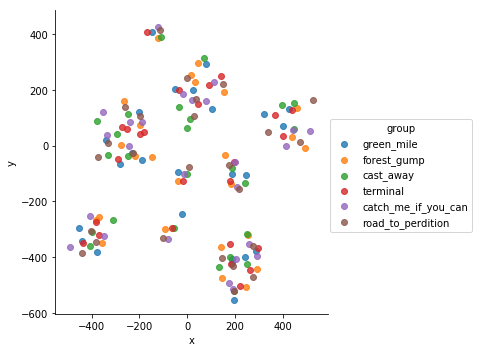

In [82]:
sns.lmplot(x='x', y='y', fit_reg=False, data=x, hue='group', x_jitter=40, y_jitter=40)